In [ ]:
from google.colab import files
files.upload()  # Upload your kaggle.json file here

# Move the uploaded kaggle.json to the correct location
# Create directory for Kaggle API token
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set permissions

Saving kaggle.json to kaggle.json


In [ ]:
# Download the GTZAN dataset
!kaggle datasets download andradaolteanu/gtzan-dataset-music-genre-classification

# Unzip the dataset
!unzip -q gtzan-dataset-music-genre-classification.zip

Dataset URL: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
License(s): other
 95% 1.16G/1.21G [00:11<00:01, 40.0MB/s]
100% 1.21G/1.21G [00:11<00:00, 112MB/s] 


In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
import time

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Display versions
print(f"TensorFlow version: {tf.__version__}")
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print(f"Librosa version: {librosa.__version__}")

TensorFlow version: 2.18.0
Num GPUs Available: 1
Librosa version: 0.11.0


## **1. Tabular Data Approach - Using Extracted Audio Features**

In [ ]:
# Load the pre-extracted features dataset (30-second segments)
features_30_sec = pd.read_csv('Data/features_30_sec.csv')

# Display the first few rows
features_30_sec.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [ ]:
# Display the first few rows
features_30_sec.shape

(1000, 60)

In [ ]:
# Check for missing values
print("Missing values per column:")
print(features_30_sec.isnull().sum())

Missing values per column:
filename                   0
length                     0
chroma_stft_mean           0
chroma_stft_var            0
rms_mean                   0
rms_var                    0
spectral_centroid_mean     0
spectral_centroid_var      0
spectral_bandwidth_mean    0
spectral_bandwidth_var     0
rolloff_mean               0
rolloff_var                0
zero_crossing_rate_mean    0
zero_crossing_rate_var     0
harmony_mean               0
harmony_var                0
perceptr_mean              0
perceptr_var               0
tempo                      0
mfcc1_mean                 0
mfcc1_var                  0
mfcc2_mean                 0
mfcc2_var                  0
mfcc3_mean                 0
mfcc3_var                  0
mfcc4_mean                 0
mfcc4_var                  0
mfcc5_mean                 0
mfcc5_var                  0
mfcc6_mean                 0
mfcc6_var                  0
mfcc7_mean                 0
mfcc7_var                  0
mfcc8_mean      

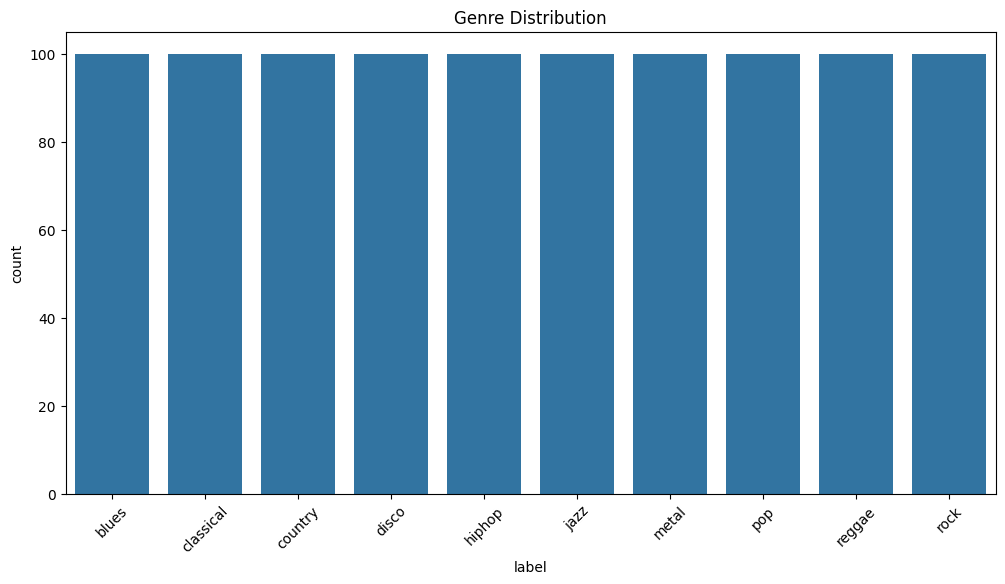

In [ ]:
# Check class distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='label', data=features_30_sec)
plt.title('Genre Distribution')
plt.xticks(rotation=45)
plt.show()

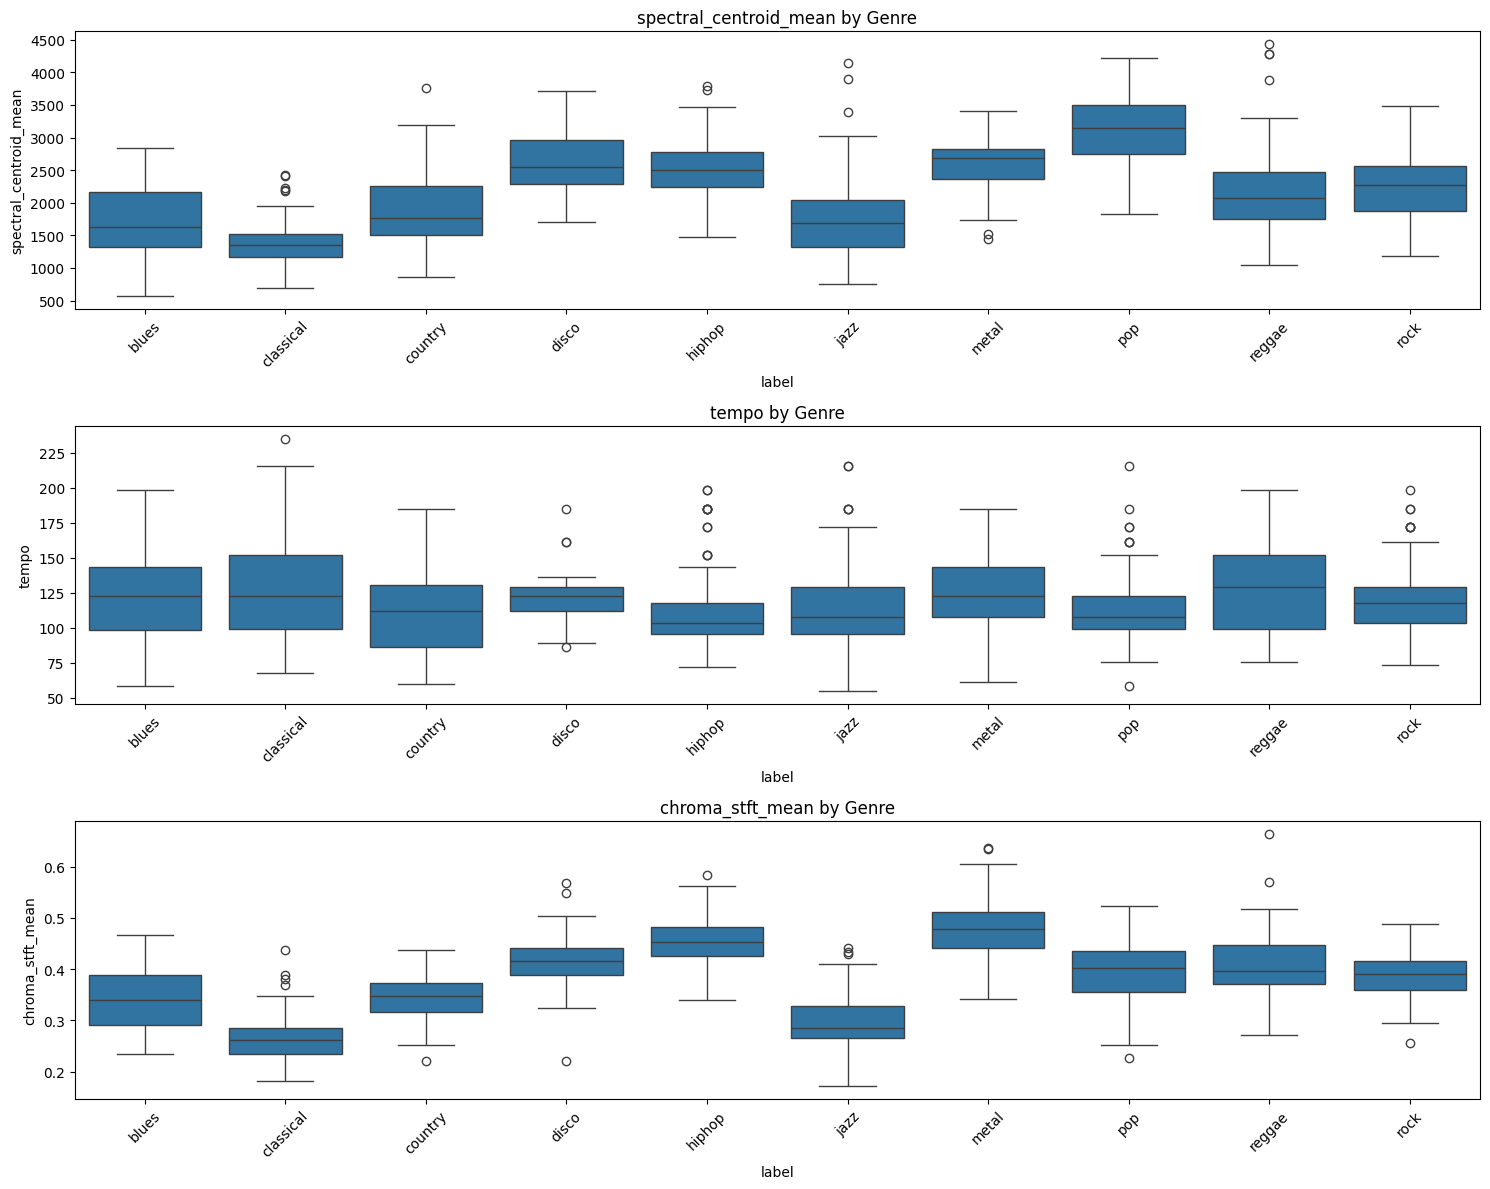

In [ ]:
features_to_plot = ['spectral_centroid_mean', 'tempo', 'chroma_stft_mean']

plt.figure(figsize=(15, 12))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(3, 1, i)
    sns.boxplot(x='label', y=feature, data=features_30_sec)
    plt.title(f'{feature} by Genre')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# Separate features and labels
X = features_30_sec.drop(columns=['filename', 'label'])
y = features_30_sec['label']

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Testing set shape: {X_test_scaled.shape}")
print(f"Number of genres: {len(np.unique(y_encoded))}")

Training set shape: (800, 58)
Testing set shape: (200, 58)
Number of genres: 10


In [ ]:
# Configure GPU memory growth to prevent TF from allocating all GPU memory
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Allow TensorFlow to allocate only as much GPU memory as needed
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU memory growth enabled for {len(gpus)} GPUs")
    except RuntimeError as e:
        print(f"Error setting memory growth: {e}")

GPU memory growth enabled for 1 GPUs


In [ ]:
# Enable mixed precision for better performance on compatible GPUs
try:
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print("Mixed precision enabled")
except:
    print("Mixed precision not available")

Mixed precision enabled


In [ ]:
# Define and train a simple feed-forward neural network for tabular data
def create_tabular_model(input_shape, num_classes):
    model = Sequential(
        [
            Input(shape=(input_shape,)),
            Dense(256, activation="relu"),
            Dropout(0.3),
            Dense(128, activation="relu"),
            Dropout(0.3),
            Dense(64, activation="relu"),
            Dropout(0.3),
            Dense(num_classes, activation="softmax"),
        ]
    )

    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )

    return model

In [ ]:
# 2. Define callbacks for training optimization
def get_training_callbacks(model_name="model"):
    # Early stopping to prevent overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    # Learning rate scheduler - reduce learning rate when plateauing
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    # Model checkpoint to save best model
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=f"{model_name}_best.keras",
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )

    return [early_stopping, reduce_lr, checkpoint]

In [ ]:
num_classes = len(np.unique(y_encoded))
tabular_model = create_tabular_model(X_train_scaled.shape[1], num_classes)

In [ ]:
tabular_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        15,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,906 (222.29 KB)

 Trainable params: 56,906 (222.29 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model with optimizations
callbacks = get_training_callbacks(model_name="tabular_model")

In [ ]:
history_tabular = tabular_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    verbose=1,
    callbacks=callbacks,
    shuffle=True,
)

Epoch 1/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 53s 6s/step - accuracy: 0.1250 - loss: 2.3736
Epoch 1: val_accuracy improved from -inf to 0.32500, saving model to tabular_model_best.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 174ms/step - accuracy: 0.1228 - loss: 2.3250 - val_accuracy: 0.3250 - val_loss: 2.1105 - learning_rate: 0.0010
Epoch 2/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1875 - loss: 2.0902
Epoch 2: val_accuracy improved from 0.32500 to 0.33750, saving model to tabular_model_best.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2596 - loss: 2.0418 - val_accuracy: 0.3375 - val_loss: 1.9133 - learning_rate: 0.0010
Epoch 3/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3594 - loss: 1.8611
Epoch 3: val_accuracy improved from 0.33750 to 0.39375, saving model to tabular_model_best.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3445 - loss: 1.8482 - val_accuracy: 0.3938 - val_loss: 1.7306 - learning_rate: 0.0010
Epoch 4/100
 1/10 ━━━━━━━━━━━━━━━━

In [ ]:
# Print training information
print(f"Best validation accuracy: {max(history_tabular.history['val_accuracy']):.4f}")
print(f"Training completed in {len(history_tabular.history['loss'])} epochs")

Best validation accuracy: 0.7000
Training completed in 29 epochs


In [ ]:
# Evaluate the tabular model
y_pred_tabular = tabular_model.predict(X_test_scaled)
y_pred_classes_tabular = np.argmax(y_pred_tabular, axis=1)

# Print accuracy
accuracy_tabular = accuracy_score(y_test, y_pred_classes_tabular)
print(f"Tabular Model Accuracy: {accuracy_tabular:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
Tabular Model Accuracy: 0.7400


In [ ]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes_tabular,
                           target_names=label_encoder.classes_))


Classification Report:
              precision    recall  f1-score   support

       blues       0.68      0.75      0.71        20
   classical       0.90      0.90      0.90        20
     country       0.74      0.85      0.79        20
       disco       0.62      0.50      0.56        20
      hiphop       0.76      0.80      0.78        20
        jazz       0.77      0.85      0.81        20
       metal       0.94      0.80      0.86        20
         pop       0.73      0.80      0.76        20
      reggae       0.62      0.80      0.70        20
        rock       0.64      0.35      0.45        20

    accuracy                           0.74       200
   macro avg       0.74      0.74      0.73       200
weighted avg       0.74      0.74      0.73       200



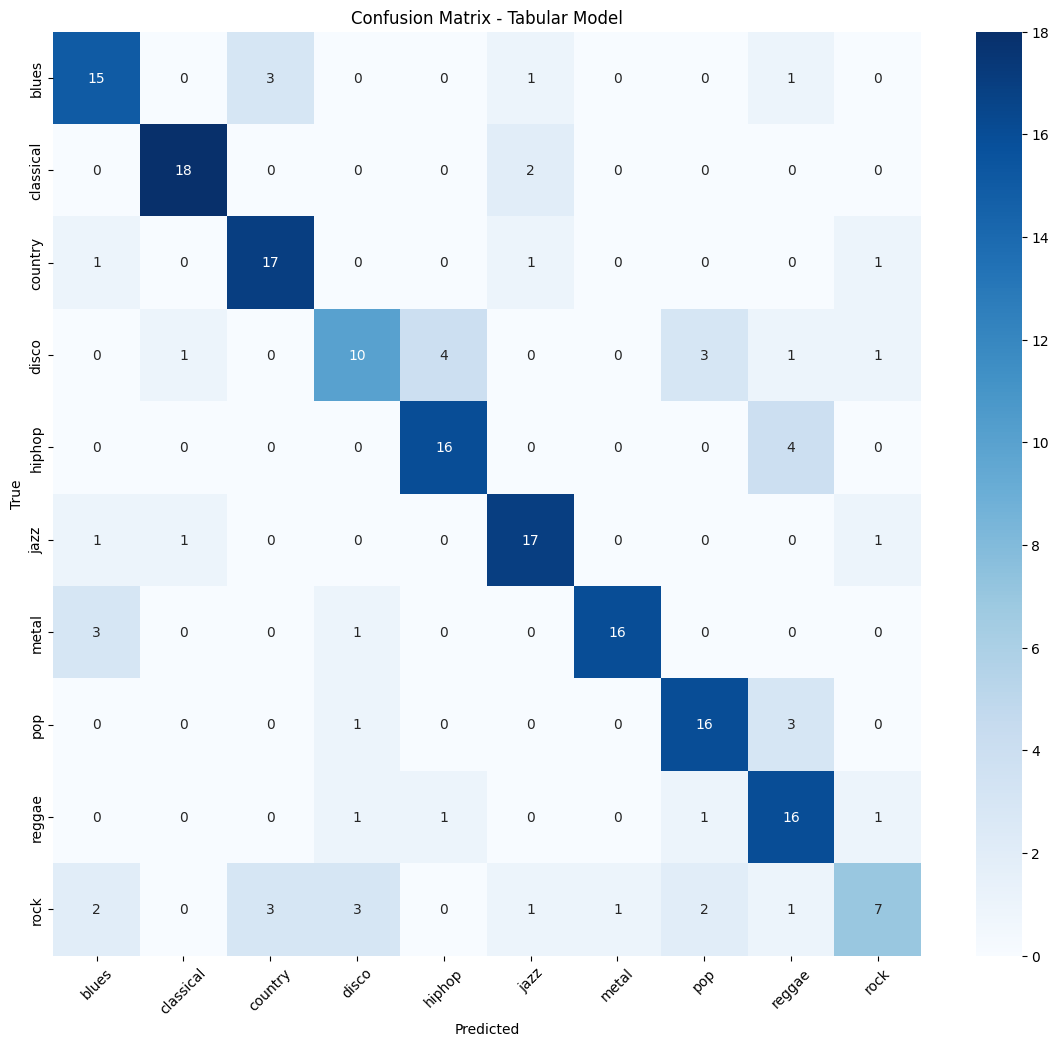

In [ ]:
# Confusion matrix
plt.figure(figsize=(14, 12))
cm = confusion_matrix(y_test, y_pred_classes_tabular)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Tabular Model')
plt.xticks(rotation=45)
plt.show()

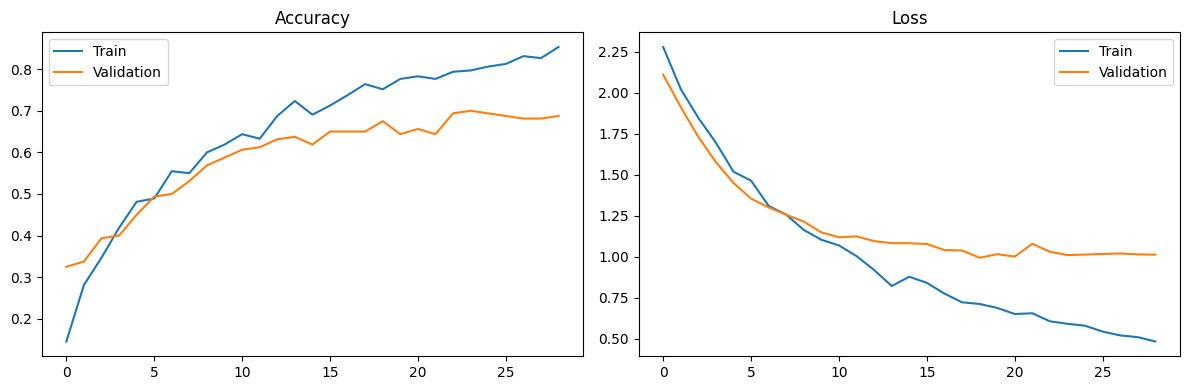

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_tabular.history['accuracy'], label='Train')
plt.plot(history_tabular.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_tabular.history['loss'], label='Train')
plt.plot(history_tabular.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## **2. Image-Based Approach - Using Spectrograms and CNN**

In [ ]:
spectrogram_dir = 'Data/images_original'

In [ ]:
# Load spectrogram images and labels from the generated spectrogram directory
def load_spectrogram_data(spectrogram_dir):
    """
    Loads spectrogram images and labels from the specified directory.

    Parameters:
    - spectrogram_dir: Directory containing genre folders with spectrogram images

    Returns:
    - X: List of spectrogram images (as numpy arrays)
    - y: List of corresponding labels (genre names)
    - genres: List of unique genre names
    """
    X = []
    y = []
    genres = sorted(os.listdir(spectrogram_dir))
    genres = [g for g in genres if os.path.isdir(os.path.join(spectrogram_dir, g))]

    for i, genre in enumerate(genres):
        genre_dir = os.path.join(spectrogram_dir, genre)
        for image_file in os.listdir(genre_dir):
            if image_file.endswith('.png'):
                image_path = os.path.join(genre_dir, image_file)
                # Load image in grayscale and convert to RGB to match the expected input shape of EfficientNet
                img = tf.keras.preprocessing.image.load_img(image_path, color_mode='rgb', target_size=(128, 128))
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                X.append(img_array)
                y.append(i)  # Append the numerical label

    X = np.array(X)
    y = np.array(y)

    return X, y, genres

# Load the spectrogram data
X_img, y_img, genres = load_spectrogram_data(spectrogram_dir)

print(f"Loaded {len(X_img)} images with shape {X_img.shape}")
print(f"Loaded {len(y_img)} labels")
print(f"Found genres: {genres}")

Loaded 999 images with shape (999, 128, 128, 3)
Loaded 999 labels
Found genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [ ]:
# Split the data
X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(
    X_img, y_img, test_size=0.2, random_state=42, stratify=y_img
)

# Convert labels to one-hot encoding for CNN
y_train_img_cat = to_categorical(y_train_img, num_classes=len(genres))
y_test_img_cat = to_categorical(y_test_img, num_classes=len(genres))

print(f"Training images: {X_train_img.shape}")
print(f"Testing images: {X_test_img.shape}")

Training images: (799, 128, 128, 3)
Testing images: (200, 128, 128, 3)


In [ ]:
from tensorflow.keras.layers import BatchNormalization, Activation

# Define CNN model for spectrogram images
def create_cnn_model(input_shape, num_classes):
    # Data augmentation for spectrograms
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomContrast(0.1),
    ])

    inputs = Input(shape=input_shape)

    # Data augmentation layer (only applied during training)
    x = data_augmentation(inputs)

    # First convolutional block
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Second convolutional block
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Third convolutional block
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Flatten and dense layers
    x = Flatten()(x)
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# Create and train optimized CNN model
cnn_model = create_cnn_model(X_train_img.shape[1:], len(genres))
# Model summary
cnn_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,486,602 (32.37 MB)

 Trainable params: 8,485,642 (32.37 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Define callbacks for optimization
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'best_cnn_model.keras',
        save_best_only=True,
        monitor='val_accuracy'
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=0.00001
    )
]

In [ ]:
# Train the CNN model with the correct data
history_cnn = cnn_model.fit(
    X_train_img,
    y_train_img_cat,
    epochs=100,  # You might need to adjust the number of epochs
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 202ms/step - accuracy: 0.1391 - loss: 2.9737 - val_accuracy: 0.1250 - val_loss: 8.8500 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.2318 - loss: 2.2353 - val_accuracy: 0.1750 - val_loss: 5.7989 - learning_rate: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.2846 - loss: 2.0032 - val_accuracy: 0.2000 - val_loss: 4.2188 - learning_rate: 0.0010
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - accuracy: 0.3459 - loss: 1.8599 - val_accuracy: 0.2812 - val_loss: 2.9347 - learning_rate: 0.0010
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.3889 - loss: 1.6559 - val_accuracy: 0.1875 - val_loss: 3.0903 - learning_rate: 0.0010
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.3600 - loss: 1.6169 - val_accuracy: 0.1875 - val_loss: 3.9175 - learning_rate: 0.0010
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.4814 - loss: 1.3696

In [ ]:
# Print training information
print(f"Best validation accuracy: {max(history_cnn.history['val_accuracy']):.4f}")
print(f"Training completed in {len(history_cnn.history['loss'])} epochs")

Best validation accuracy: 0.5063
Training completed in 30 epochs


In [ ]:
# Evaluate the CNN model after retraining
y_pred_cnn = cnn_model.predict(X_test_img)
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)

# Print accuracy
accuracy_cnn = accuracy_score(y_test_img, y_pred_classes_cnn)
print(f"CNN Model Accuracy: {accuracy_cnn:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
CNN Model Accuracy: 0.6150


In [ ]:
# Classification report after retraining
print("\nClassification Report:")
print(classification_report(y_test_img, y_pred_classes_cnn,
                           target_names=genres))


Classification Report:
              precision    recall  f1-score   support

       blues       0.86      0.60      0.71        20
   classical       0.81      0.85      0.83        20
     country       0.83      0.25      0.38        20
       disco       0.63      0.60      0.62        20
      hiphop       0.34      0.85      0.49        20
        jazz       0.62      0.80      0.70        20
       metal       0.75      0.90      0.82        20
         pop       0.52      0.60      0.56        20
      reggae       0.91      0.50      0.65        20
        rock       0.67      0.20      0.31        20

    accuracy                           0.61       200
   macro avg       0.69      0.61      0.60       200
weighted avg       0.69      0.61      0.60       200



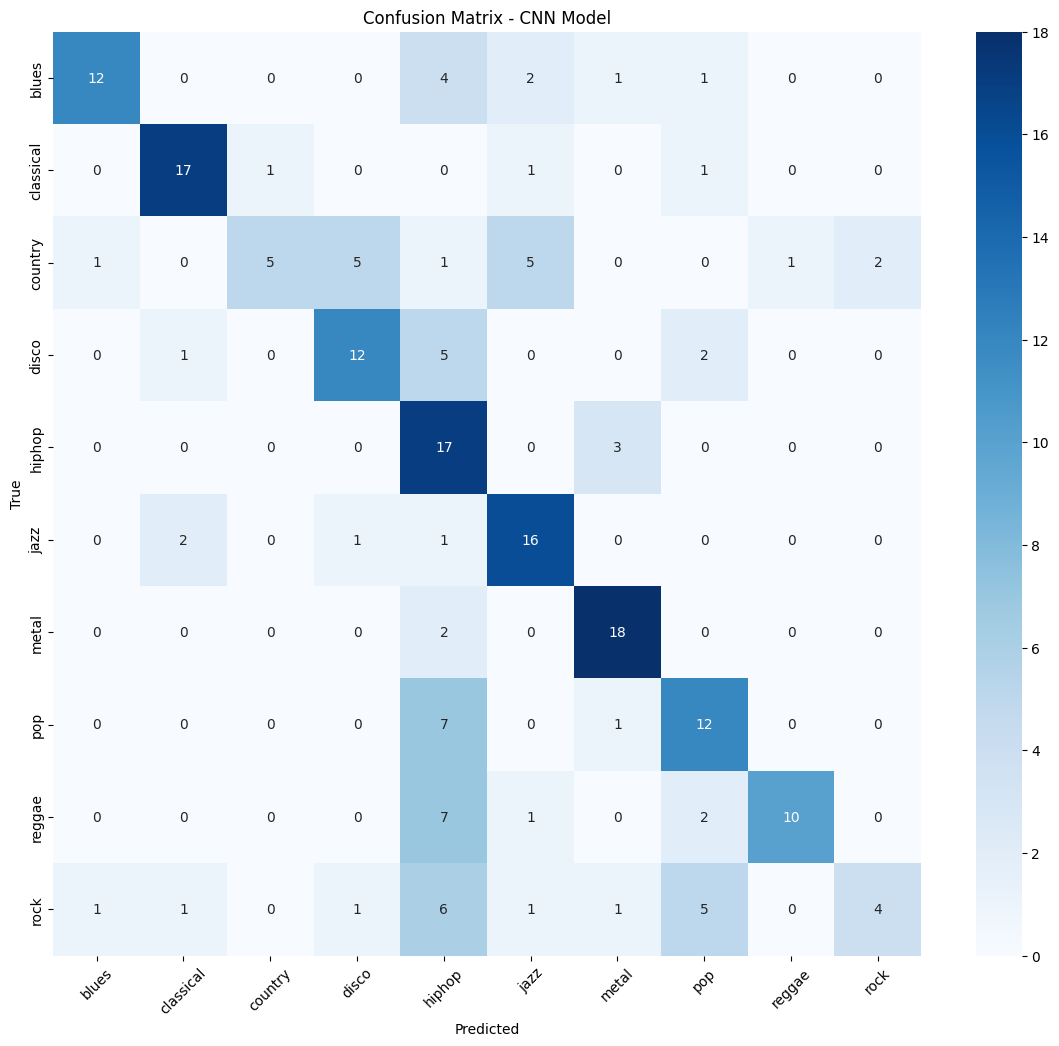

In [ ]:
# Confusion matrix after retraining
plt.figure(figsize=(14, 12))
cm_cnn = confusion_matrix(y_test_img, y_pred_classes_cnn)
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=genres,
            yticklabels=genres)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - CNN Model')
plt.xticks(rotation=45)
plt.show()

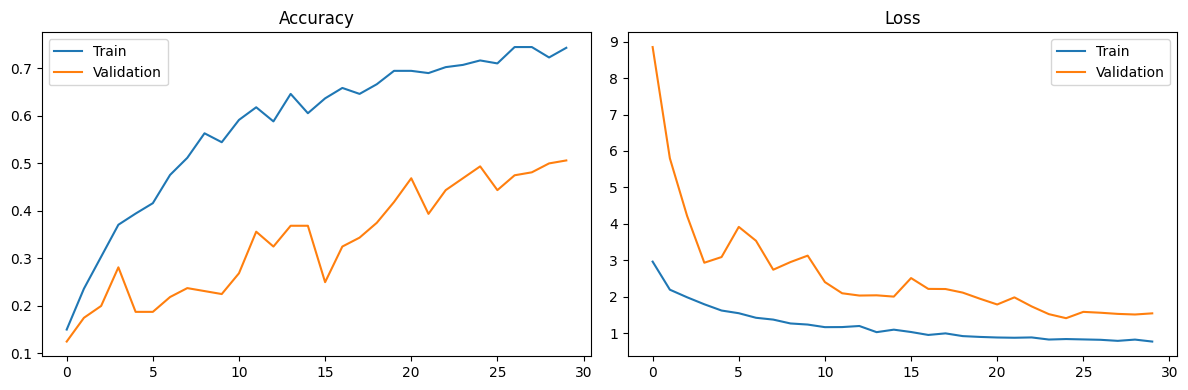

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Train')
plt.plot(history_cnn.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Train')
plt.plot(history_cnn.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## **3. Transfer Learning with Pre-trained CNN**

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
def create_efficientnet_model(input_shape, num_classes):
    """
    Create a pre-trained EfficientNetB0 model ready for fine-tuning
    """
    # Create input layer
    inputs = Input(shape=input_shape)

    # Load pre-trained EfficientNetB0 without top layer
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs
    )

    # Unfreeze only the last 30 layers for fine-tuning
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    for layer in base_model.layers[-30:]:
        layer.trainable = True

    # Add classification head
    x = GlobalAveragePooling2D()(base_model.output)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile with a lower learning rate for fine-tuning
    model.compile(
        optimizer=Adam(learning_rate=5e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
# Create the model for fine-tuning
efficientnet_model = create_efficientnet_model(X_train_img.shape[1:], len(genres))

# Display model architecture summary
efficientnet_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_2 (Cast)       │ (None, 128, 128,  │          0 │ input_layer_3[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ cast_2[0][0]      │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 128, 128,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati

 Total params: 4,386,221 (16.73 MB)

 Trainable params: 1,829,738 (6.98 MB)

 Non-trainable params: 2,556,483 (9.75 MB)

In [ ]:
# Define callbacks for optimized fine-tuning
callbacks = [
    # Save best model
    tf.keras.callbacks.ModelCheckpoint(
        'best_finetuned_efficientnet.keras',
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    ),

    # Early stopping
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=6,
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce learning rate
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

In [ ]:
# Fine-tune the model
print("Fine-tuning EfficientNet model...")
history_finetune = efficientnet_model.fit(
    X_train_img,
    y_train_img_cat,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Fine-tuning EfficientNet model...
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0885 - loss: 3.5601  
Epoch 1: val_accuracy improved from -inf to 0.08125, saving model to best_finetuned_efficientnet.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.0889 - loss: 3.5574 - val_accuracy: 0.0812 - val_loss: 2.3748 - learning_rate: 5.0000e-05
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1308 - loss: 3.0988
Epoch 2: val_accuracy improved from 0.08125 to 0.13750, saving model to best_finetuned_efficientnet.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.1315 - loss: 3.0951 - val_accuracy: 0.1375 - val_loss: 2.3101 - learning_rate: 5.0000e-05
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1970 - loss: 2.7202
Epoch 3: val_accuracy improved from 0.13750 to 0.18125, saving model to best_finetuned_efficientnet.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.1979 - loss: 2.7188 - val_accuracy: 0.1813 - val_los

In [ ]:
# Comprehensive evaluation
print("Evaluating fine-tuned EfficientNet model:")
test_loss, test_accuracy = efficientnet_model.evaluate(X_test_img, y_test_img_cat, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Evaluating fine-tuned EfficientNet model:
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5022 - loss: 1.4266
Test Loss: 1.4879
Test Accuracy: 0.4850


In [ ]:
# Make predictions
y_pred_probs = efficientnet_model.predict(X_test_img)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_test_classes = np.argmax(y_test_img_cat, axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step


In [ ]:
# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=genres))


Classification Report:
              precision    recall  f1-score   support

       blues       0.62      0.40      0.48        20
   classical       0.69      0.90      0.78        20
     country       0.53      0.45      0.49        20
       disco       0.29      0.30      0.29        20
      hiphop       0.50      0.35      0.41        20
        jazz       0.60      0.60      0.60        20
       metal       0.70      0.80      0.74        20
         pop       0.40      0.50      0.44        20
      reggae       0.33      0.40      0.36        20
        rock       0.18      0.15      0.16        20

    accuracy                           0.48       200
   macro avg       0.48      0.49      0.48       200
weighted avg       0.48      0.48      0.48       200



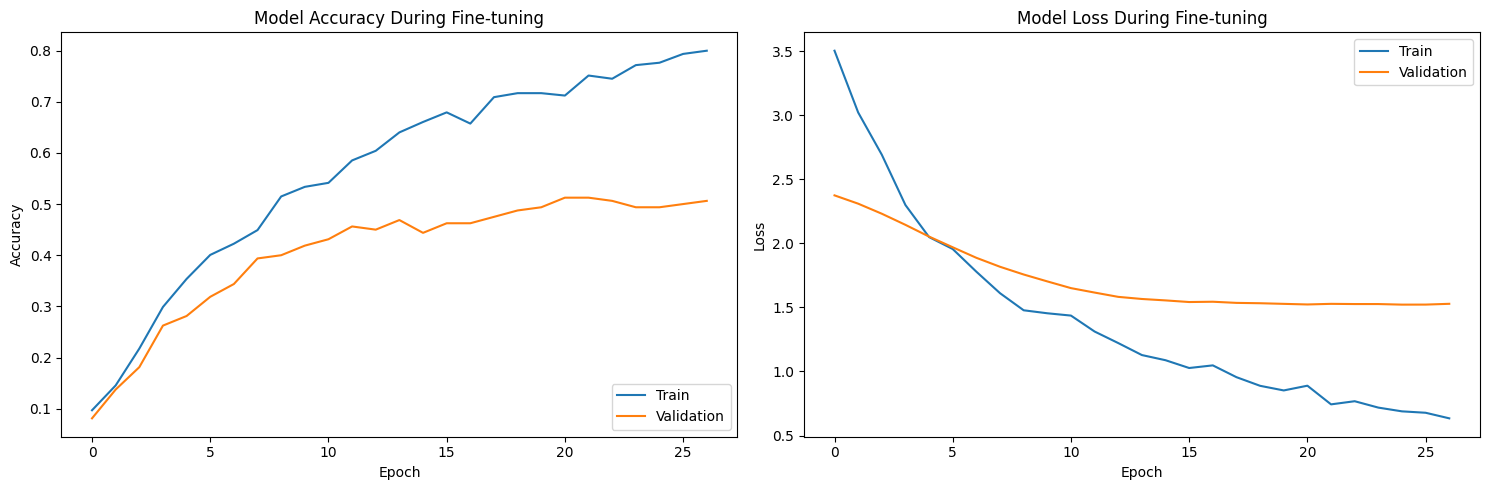

In [ ]:
# Visualize training history
plt.figure(figsize=(15, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history_finetune.history['accuracy'], label='Train')
plt.plot(history_finetune.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy During Fine-tuning')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_finetune.history['loss'], label='Train')
plt.plot(history_finetune.history['val_loss'], label='Validation')
plt.title('Model Loss During Fine-tuning')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

## **4. Model Comparison and Evaluation**

In [ ]:
# Function to visualize model predictions
def visualize_predictions(model, X_test, y_test, label_encoder, is_categorical=False):
    """
    Visualize model predictions and actual labels

    Parameters:
    - model: Trained model
    - X_test: Test features
    - y_test: True labels
    - label_encoder: LabelEncoder for converting indices to genre names
    - is_categorical: Whether y_test is already one-hot encoded
    """
    # Get predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    if is_categorical:
        y_test_indices = np.argmax(y_test, axis=1)
    else:
        y_test_indices = y_test

    # Calculate accuracy
    accuracy = np.mean(y_pred == y_test_indices)
    print(f"Test Accuracy: {accuracy:.4f}")

    # Convert indices to genre names
    try:
        genres = label_encoder.classes_
    except:
        genres = label_encoder

    # Plot confusion matrix
    cm = confusion_matrix(y_test_indices, y_pred)
    plt.figure(figsize=(14, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=genres,
                yticklabels=genres)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45)
    plt.show()

    # Plot sample predictions
    n_samples = 10
    indices = np.random.choice(range(len(X_test)), n_samples, replace=False)

    for i, idx in enumerate(indices):
        true_label = genres[y_test_indices[idx]]
        pred_label = genres[y_pred[idx]]

        print(f"Sample {i+1}: True: {true_label}, Predicted: {pred_label}")

Evaluating CNN model:
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Test Accuracy: 0.6150


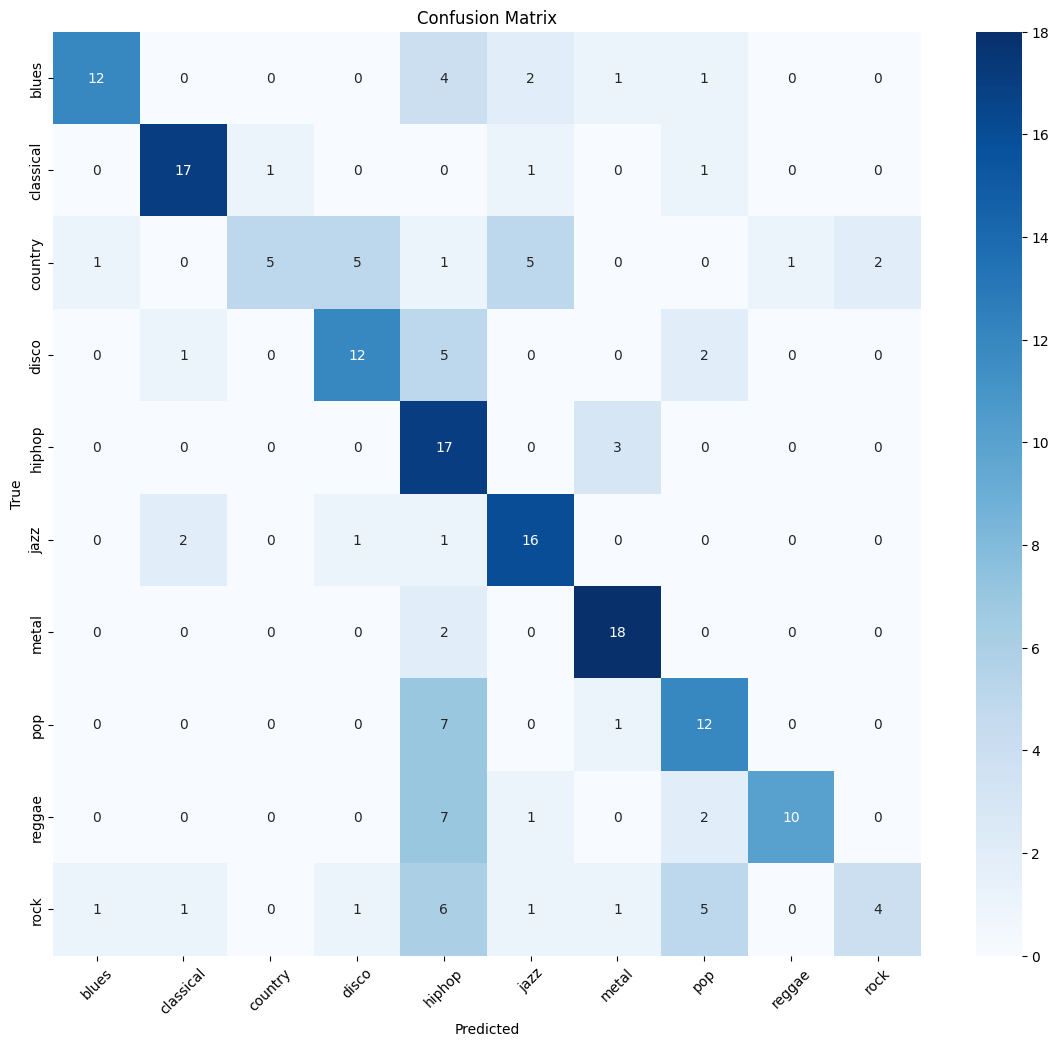

Sample 1: True: jazz, Predicted: jazz
Sample 2: True: disco, Predicted: pop
Sample 3: True: metal, Predicted: metal
Sample 4: True: classical, Predicted: pop
Sample 5: True: metal, Predicted: metal
Sample 6: True: country, Predicted: disco
Sample 7: True: pop, Predicted: pop
Sample 8: True: metal, Predicted: metal
Sample 9: True: pop, Predicted: pop
Sample 10: True: jazz, Predicted: jazz


In [ ]:
# Evaluate the CNN model
print("Evaluating CNN model:")
visualize_predictions(cnn_model, X_test_img, y_test_img_cat, genres, is_categorical=True)


Evaluating Transfer Learning model:
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test Accuracy: 0.4850


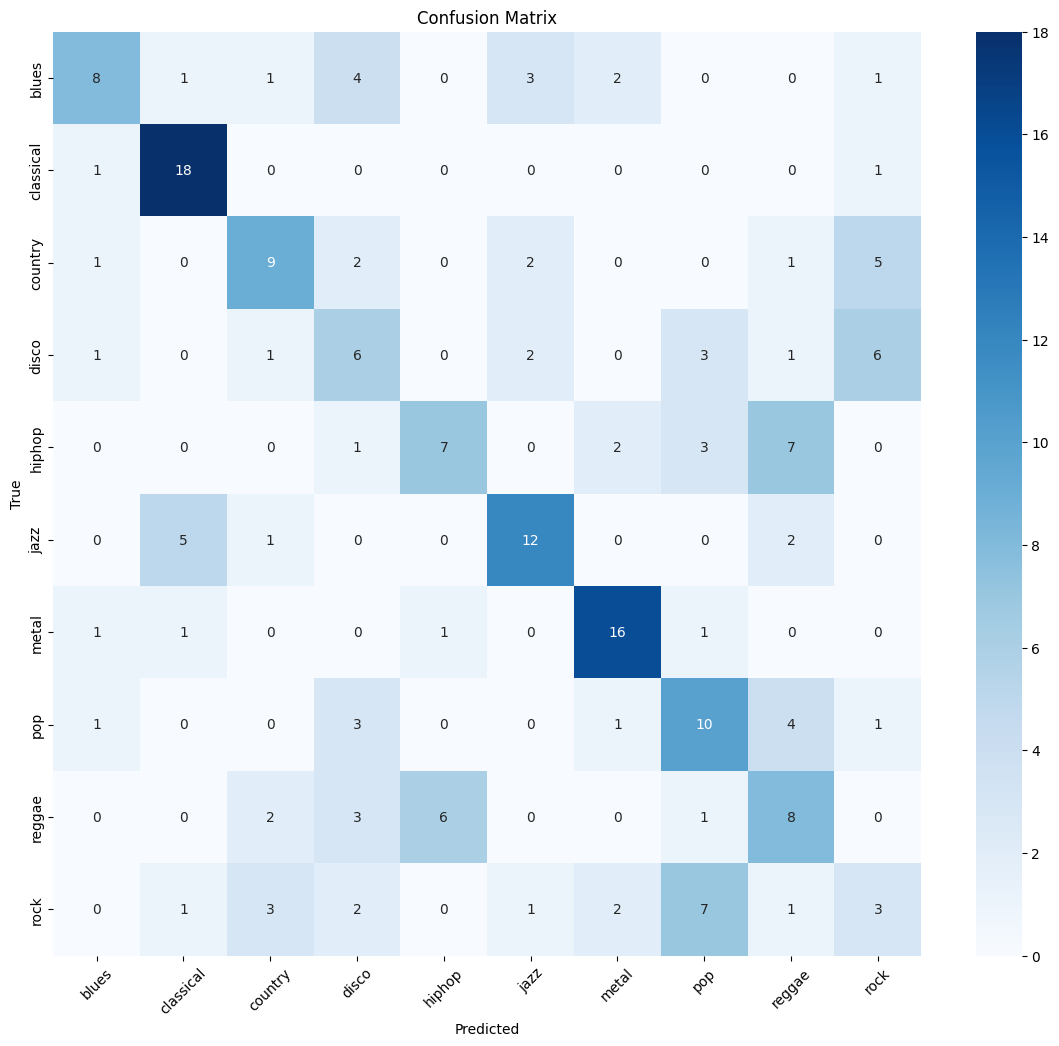

Sample 1: True: pop, Predicted: reggae
Sample 2: True: hiphop, Predicted: reggae
Sample 3: True: blues, Predicted: country
Sample 4: True: metal, Predicted: metal
Sample 5: True: reggae, Predicted: hiphop
Sample 6: True: country, Predicted: jazz
Sample 7: True: rock, Predicted: rock
Sample 8: True: disco, Predicted: rock
Sample 9: True: rock, Predicted: metal
Sample 10: True: reggae, Predicted: hiphop


In [ ]:
# Evaluate the transfer learning model
print("\nEvaluating Transfer Learning model:")
visualize_predictions(efficientnet_model, X_test_img, y_test_img_cat, genres, is_categorical=True)

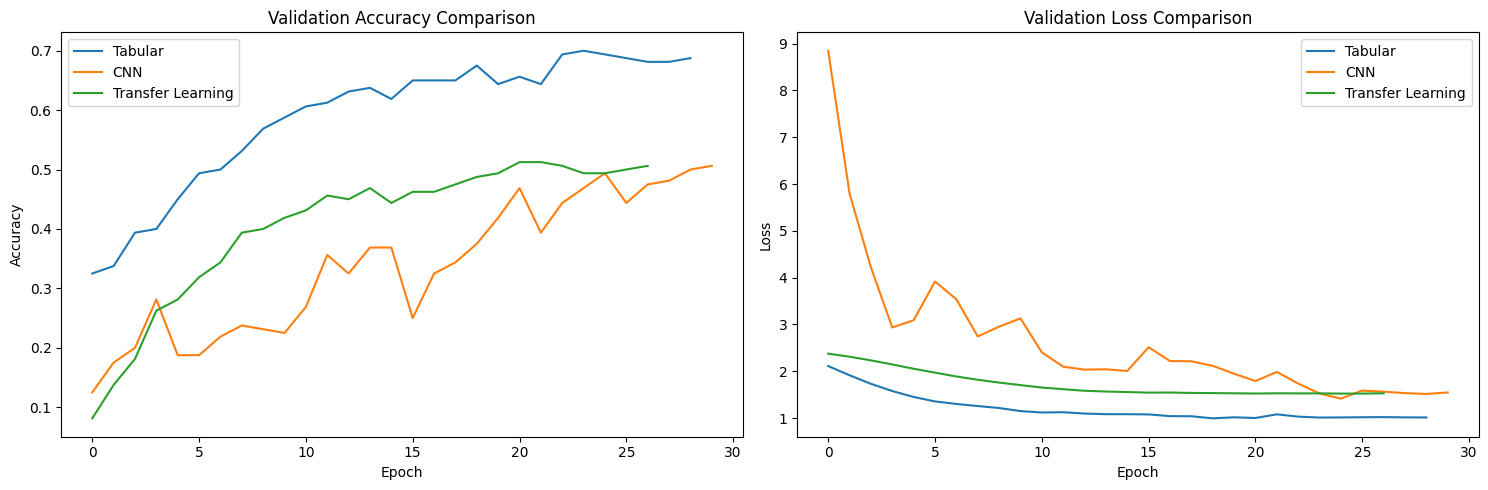


Model Performance Summary:
Tabular Model Accuracy: 0.7400
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
CNN Model Accuracy: 0.6150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Transfer Learning Model Accuracy: 0.4850


In [ ]:
# Plot training history comparison
plt.figure(figsize=(15, 5))

# Accuracy comparison
plt.subplot(1, 2, 1)
plt.plot(history_tabular.history['val_accuracy'], label='Tabular')
plt.plot(history_cnn.history['val_accuracy'], label='CNN')
plt.plot(history_finetune.history['val_accuracy'], label='Transfer Learning')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss comparison
plt.subplot(1, 2, 2)
plt.plot(history_tabular.history['val_loss'], label='Tabular')
plt.plot(history_cnn.history['val_loss'], label='CNN')
plt.plot(history_finetune.history['val_loss'], label='Transfer Learning')
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Summary of model performances
print("\nModel Performance Summary:")
print("=" * 50)
print(f"Tabular Model Accuracy: {accuracy_tabular:.4f}")

# Calculate accuracy for CNN model
y_pred_cnn = cnn_model.predict(X_test_img)
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)
y_test_classes = np.argmax(y_test_img_cat, axis=1)
accuracy_cnn = np.mean(y_pred_classes_cnn == y_test_classes)
print(f"CNN Model Accuracy: {accuracy_cnn:.4f}")

# Calculate accuracy for transfer learning model
y_pred_transfer = efficientnet_model.predict(X_test_img)
y_pred_classes_transfer = np.argmax(y_pred_transfer, axis=1)
accuracy_transfer = np.mean(y_pred_classes_transfer == y_test_classes)
print(f"Transfer Learning Model Accuracy: {accuracy_transfer:.4f}")
print("=" * 50)